In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [66]:
data = pd.read_csv('titanic_train.csv')

In [67]:
data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [68]:
data = data.drop(columns=['PassengerId', 'Name', 'Parch', 'SibSp', 'Cabin', 'Embarked', 'Ticket'])

In [69]:
#some very quick cleaning
data.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
Fare          0
dtype: int64

In [70]:
data['Age'].mean()

29.69911764705882

In [71]:
#fill with the agerage age
data['Age'] = data['Age'].fillna(data['Age'].mean())

In [72]:
class_dummies = pd.get_dummies(data['Pclass'])
sex_dummies = pd.get_dummies(data['Sex'])

In [73]:
data = pd.concat([data, class_dummies, sex_dummies], axis=1)
data = data.drop(columns = ['Pclass', 'Sex'])

In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived    891 non-null int64
Age         891 non-null float64
Fare        891 non-null float64
1           891 non-null uint8
2           891 non-null uint8
3           891 non-null uint8
female      891 non-null uint8
male        891 non-null uint8
dtypes: float64(2), int64(1), uint8(5)
memory usage: 25.3 KB


In [208]:
#normalize the data to make life easier when using a sigmoid (if values are too big everything will go to -1 or 1)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data.iloc[:, 1:] = scaler.fit_transform(data.iloc[:, 1:])

### Attempt Logistic regression with numpy

In [361]:
#allocate data to small x and y
x = data.iloc[:, 1:]
y = data.iloc[:,0]
print('X: {}  Y: {}'.format(X.shape, Y.shape))
x.head()

X: (891, 9)  Y: (891, 1)


Age      Fare         1         2         3    female      male
0 -0.592481 -0.502445 -0.565685 -0.510152  0.902587 -0.737695  0.737695
1  0.638789  0.786845  1.767767 -0.510152 -1.107926  1.355574 -1.355574
2 -0.284663 -0.488854 -0.565685 -0.510152  0.902587  1.355574 -1.355574
3  0.407926  0.420730  1.767767 -0.510152 -1.107926  1.355574 -1.355574
4  0.407926 -0.486337 -0.565685 -0.510152  0.902587 -0.737695  0.737695

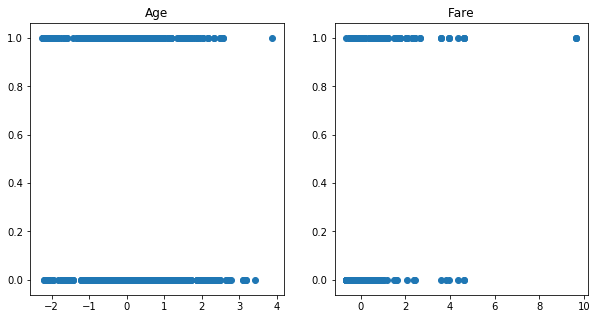

In [275]:
#plot Y vs X variables age and fare.
#not able to plot the dummy variables
fig, axs = plt.subplots(1, 2, figsize=(10,5))

cols = ['Age', 'Fare']

for ax, col in zip(axs,cols):
    x_chart = x[col].values
    y_chart = y.values
    ax.scatter(x_chart, y_chart)
    ax.set_title(col)
    
#note that 1 is survived, 0 is did not.

In [413]:
#set the starting values for X, a vector of features, and Y, the vector of survived or not.
X = x.values
Y = np.resize(y.values, (y.values.shape[0], 1))

In [277]:
#define a sigmoid function
def sigmoid(X):
    num = np.exp(X)
    denom = np.exp(X)+ 1
    return num / denom

In [278]:
sigmoid(10)

0.9999546021312976

### Short explanation of what I'm trying to do

Let b be a vector [b0, b1, b2, ...bn] of weights for each of the feature vectors in X

Where b = [b0, b1, b2] X = [x0, x1, x2] such that it produces a set of linear equations of the form b0 + b1x1 + b2x2 and x0 = 1 by default

Y = b * X.T

The probability of the set is described as: 
P(Y) = sigmoid(Y) / (sigmoid(Y) - 1)

Where Y is a vector [y1, y2...]

In this example X is shape (m, 7) and Y is (m, 1)


This allows us to predict a single fit (i.e. one line) with arbitrary values of b. In order to update b we need to use a function such that taking its derivative allows us to update b to minimize the function.

#### Cost function:
For the whole of the set of predictions (Y_hat) for a any value of b we can evaluate how wrong we are with a cost function.

cost = 1/m * sum( y * log(y_hat) + (1 - y) * log (1 - y_hat)  )

Note that if y = 1 we only consider the term y * log(y_hat). And if y= 0 we only consider (1 - y) * log (1 - y_hat)

This has the following effect:
If y = y_hat the element value will be small 
(i.e. y, y_hat = 1 * log 1, cost = 0 OR  y, y_hat = 0 (1-0) * log(1), cost = 0 )

If y != y_hat the element value will be very large 
(i.e. y= 1 y_hat = 0 then 1 * log (0), cost = -inf OR  y = 0, y_hat = 1 then (1-0) * log(0), cost = -inf


The derivative of the cost function is:
dcost = 1/m * X(Y_hat - Y).T

Where X is the feature vector, and Y_hat and Y are vectors of the result set. m is the number of samples. 

In [414]:
#function to add x0 to the feature matrix

def add_x0(X):
    
    m, n_feat = X.shape[0], X.shape[1]
    
    one_vector = np.ones((m,1))
    
    X = np.concatenate([one_vector, X], axis=1)
    
    return X
    

In [415]:
#initalize X with the x0 term
X = add_x0(X)
X.shape

(891, 8)

In [412]:
#generate random starting coefficents. if we initalize to zero all Y_hats will be zero.
def initalize_b(X):
    """
    Creates our best guess for the values of b
    
    """
    
    m, n_feat = X.shape[0], X.shape[1]
    
    #np.random.seed(42)
    
    b = np.random.randn((n_feat))
    
    b = np.resize(b, (b.shape[0], 1))
    
    return b

In [418]:
b_test = initalize_b(X)
b_test

array([[ 0.34361829],
       [-1.76304016],
       [ 0.32408397],
       [-0.38508228],
       [-0.676922  ],
       [ 0.61167629],
       [ 1.03099952],
       [ 0.93128012]])

In [419]:
#calculate first forward pass on our prior
def forward_probs(X, b, test = False):
    
#     print('X: {}'.format(X.shape))
#     print('b: {}'.format(b.shape))
    
    if test == True:
        b = initalize_b(X).copy()
    
    
    Y_hat = np.dot(X,b)
    Y_hat = sigmoid(Y_hat)
    
    return X, b, Y_hat

In [423]:
X_test, b_test, Y_hat_test = forward_probs(X, b_test, test=True)
X_test.shape, b_test.shape, Y.shape, Y_hat.shape

((891, 8), (8, 1), (891, 1), (891, 1))

In [424]:
# now have enough information to evaluate our first fit of the data. 
# We initalized the data to a uniform random distribtuions so
# when we return Y_hat from forward_probs and use the evaluate function to determine our accuracy 
# expect 50%

evaluate(Y, Y_hat_test)

44.55667789001122

In [425]:
#calcualte logistic loss function. return the cost and the derivative of cost
def cost(X, Y, Y_hat):
    
    m = Y.shape[0]
    
    cost = (-1/m) * np.sum(np.multiply(Y,np.log(Y_hat)) + np.multiply((1-Y),np.log(1-Y_hat)))# compute cost
#     print(Y.shape)
#     print(Y_hat.shape)
#     print(X.shape)
    dcost = (1/m) * np.dot(X.T, (Y_hat-Y))
    
    return cost, dcost

In [426]:
cost(X, Y, Y_hat)

(0.45183337908078075, array([[ 1.54874384e-10],
        [ 1.08012912e-09],
        [ 1.66353524e-09],
        [-1.32679704e-09],
        [ 3.50291234e-10],
        [ 8.58087619e-10],
        [-2.34689511e-10],
        [ 2.34689511e-10]]))

In [427]:
#function for gradient descent
def grad_descent(X, b, Y, num_iterations = 10, learning_rate = 0.01):
    """
    Steps:
    1. Calculate the probabilites of survival
    2. Caclculate the cost
    3. Update the cost gradients
    
    """
    
    b = initalize_b(X)
    
    print(X.shape)
    print(b.shape)
    
    for i in range(num_iterations):
        
        X, b, Y_hat = forward_probs(X, b)
        
        c, dcost = cost(X, Y, Y_hat)
        
        b = b - learning_rate * dcost
        
    return X, b, Y_hat
    
    

In [428]:
X, b, Y_hat = grad_descent(X, b, Y, num_iterations=500, learning_rate = 0.5)

(891, 8)
(8, 1)


In [317]:
def evaluate(Y, Y_hat):
    
    m = Y.shape[0]
    
    Y_prediction = np.where(Y_hat > 0.5, 1, 0)
    
    performance = np.sum(Y_prediction == Y)/m
    
    return performance * 100
    

In [429]:
#evaluate again after fitting b
evaluate(Y, Y_hat)

80.02244668911335

In [430]:
#print the final coefficents
b

array([[-0.64888116],
       [-0.42910829],
       [ 0.03574747],
       [ 0.70574605],
       [ 0.22963332],
       [-0.31497117],
       [-0.32570521],
       [-1.57010293]])